In [15]:
########################################
# Packages
########################################
import warnings
import h5py as h5
import numpy as np
import pandas as pd
import multiprocessing as mp

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import math

import statistics

from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic
import scipy.stats.distributions as dist

import seaborn as sns

In [17]:
########################################
# Functions and values
########################################
h0=0.6751    # h0 value used for the SURFS DM-only simulation used to generate these outputs (Planck+2015)
Gyr2yr=1e9
ncpu=128    # Number of cores, only important if reading the files in parallel (see near the end of the code)
warnings.filterwarnings('ignore',message='invalid value encountered in divide')

In [19]:
def SHARK_parallel_read(shark_file,sv):
    shark_hdf5=h5.File(shark_file)
    
    gal_sv={}
    
    # Shark properties
    # Note the modification of galaxy/group IDs. This is because these IDs are only unique per subvolume, i.e.,
    # you can have up to 64 galaxies with with the same ID (one per each simulation subvolume).
    # If you want the true IDs it would be as simple as replacing these lines with something like
    # gal_sv['ID_galaxy']=shark_hdf5['galaxies']['id_galaxy'][()]
    gal_sv['ID_galaxy']=np.array([f'{sv}_{gid}' for gid in shark_hdf5['galaxies']['id_galaxy'][()]])
    gal_sv['ID_subhalo']=np.array([f'{sv}_{hid}' for hid in shark_hdf5['galaxies']['id_subhalo'][()]])
    gal_sv['ID_subhalo_tree']=np.array([f'{sv}_{hid}' for hid in shark_hdf5['galaxies']['id_subhalo_tree'][()]])
    gal_sv['ID_halo']=np.array([f'{sv}_{hid}' for hid in shark_hdf5['galaxies']['id_halo'][()]])
    gal_sv['sv']=(np.ones(len(shark_hdf5['galaxies']['id_galaxy'][()]))*sv).astype('int')
    gal_sv['type']=shark_hdf5['galaxies']['type'][()]
    # Halo masses
    gal_sv['Mhalo_host']=shark_hdf5['galaxies']['mvir_hosthalo'][()].astype('float64')/h0
    gal_sv['Mhalo']=shark_hdf5['galaxies']['mvir_subhalo'][()].astype('float64')/h0
    # Stellar masses
    gal_sv['Mstar_bulge']=shark_hdf5['galaxies']['mstars_bulge'][()].astype('float64')/h0
    gal_sv['Mstar_disc']=shark_hdf5['galaxies']['mstars_disk'][()].astype('float64')/h0
    gal_sv['Mstar_all']=gal_sv['Mstar_bulge']+gal_sv['Mstar_disc']
    gal_sv['Mstar_stripped']=shark_hdf5['galaxies']['mstars_tidally_stripped'][()].astype('float64')/h0
    # Gas masses
    gal_sv['Mhotgas']=shark_hdf5['galaxies']['mhot'][()].astype('float64')/h0
    gal_sv['Mcoldgas_bulge']=shark_hdf5['galaxies']['mgas_bulge'][()].astype('float64')/h0
    gal_sv['Mcoldgas_disc']=shark_hdf5['galaxies']['mgas_disk'][()].astype('float64')/h0 
    gal_sv['Mcoldgas_all']=gal_sv['Mcoldgas_bulge']+gal_sv['Mcoldgas_disc']
    # Galaxy sizes
    gal_sv['Rgas_bulge']=1e3*shark_hdf5['galaxies']['rgas_bulge'][()].astype('float64')/h0
    gal_sv['Rgas_disc']=1e3*shark_hdf5['galaxies']['rgas_disk'][()].astype('float64')/h0
    gal_sv['Rgas_all']=(gal_sv['Mstar_bulge']*gal_sv['Rgas_bulge']+gal_sv['Mstar_disc']*gal_sv['Rgas_disc'])/gal_sv['Mstar_all']
    gal_sv['Rstar_bulge']=1e3*shark_hdf5['galaxies']['rstar_bulge'][()].astype('float64')/h0
    gal_sv['Rstar_disc']=1e3*shark_hdf5['galaxies']['rstar_disk'][()].astype('float64')/h0
    gal_sv['Rstar_all']=(gal_sv['Mstar_bulge']*gal_sv['Rstar_bulge']+gal_sv['Mstar_disc']*gal_sv['Rstar_disc'])/gal_sv['Mstar_all']
    # SFR
    gal_sv['SFR_bulge']=shark_hdf5['galaxies']['sfr_burst'][()].astype('float64')/(h0*Gyr2yr)
    gal_sv['SFR_disc']=shark_hdf5['galaxies']['sfr_disk'][()].astype('float64')/(h0*Gyr2yr)
    gal_sv['SFR_all']=gal_sv['SFR_bulge']+gal_sv['SFR_disc']
    # BH properties
    gal_sv['MBH']=shark_hdf5['galaxies']['m_bh'][()].astype('float64')/h0
    gal_sv['MBHacc_cold']=shark_hdf5['galaxies']['bh_accretion_rate_sb'][()].astype('float64')/(h0*Gyr2yr)
    gal_sv['MBHacc_hot']=shark_hdf5['galaxies']['bh_accretion_rate_hh'][()].astype('float64')/(h0*Gyr2yr)
    gal_sv['MBHacc_all']=gal_sv['MBHacc_cold']+gal_sv['MBHacc_hot']
    # Ejected gas
    gal_sv['Mgas_lost_SF']=shark_hdf5['galaxies']['mreheated'][()].astype('float64')/h0
    gal_sv['Mgas_lost_QSO']=shark_hdf5['galaxies']['mlost'][()].astype('float64')/h0
    gal_sv['BHspin']=shark_hdf5['galaxies']['bh_spin'][()]
    
    # pandas DataFrame
    gal_sv=pd.DataFrame(gal_sv)
    gal_sv=gal_sv.drop(gal_sv[gal_sv['Mstar_all']>1e8].index)    # Galaxies below this mass tend to reside in poorly-resolved haloes
    shark_hdf5.close()
    
    return(gal_sv)

In [21]:
########################################
# Reading data
########################################
sv_list=np.arange(64)
sharkfiles=[f'extracted_data_z=0/199/{sv}/galaxies.hdf5' for sv in sv_list] 

# To read in parallel
#pool=mp.Pool(processes=ncpu)
#shark_csv=[pool.apply_async(SHARK_parallel_read,(sf,sv,)) for sf,sv in zip(sharkfiles,sv_list)]
#shark_csv=[sc.get() for sc in shark_csv]
#pool.close()

# Otherwise use this
shark_csv=[SHARK_parallel_read(sf,sv) for sf,sv in zip(sharkfiles,sv_list)] 
shark_csv=pd.concat(shark_csv,ignore_index=True)

In [27]:
print(shark_csv.head())
print('shape: ', len(shark_csv))

  ID_galaxy ID_subhalo    ID_subhalo_tree ID_halo  sv  type    Mhalo_host  \
0  0_516974        0_1  0_199000000000184     0_1   0     2  1.553645e+12   
1  0_528022        0_1  0_199000000000184     0_1   0     2  1.553645e+12   
2  0_289627        0_1  0_199000000000184     0_1   0     2  1.553645e+12   
3  0_516973        0_1  0_199000000000184     0_1   0     2  1.553645e+12   
4  0_522534        0_1  0_199000000000184     0_1   0     2  1.553645e+12   

          Mhalo   Mstar_bulge    Mstar_disc  ...  SFR_bulge  SFR_disc  \
0  6.547178e+09  0.000000e+00  0.000000e+00  ...        0.0  0.000000   
1  1.735002e+10  0.000000e+00  0.000000e+00  ...        0.0  0.000000   
2  7.201896e+09  1.537014e+06  6.966537e+06  ...        0.0  0.000002   
3  8.183973e+09  0.000000e+00  0.000000e+00  ...        0.0  0.000000   
4  7.201896e+09  0.000000e+00  0.000000e+00  ...        0.0  0.000000   

    SFR_all           MBH  MBHacc_cold  MBHacc_hot  MBHacc_all  Mgas_lost_SF  \
0  0.000000      0

In [5]:
########################################
# gal_sv settings
########################################
# type: galaxy type; =0 for centrals; =1 for satellites that reside in well identified subhalos; =2 for orphan satellites

shark_csv_centrals = shark_csv[(shark_csv['type'] == 0)] ######## Centrals only
shark_csv_satellites = shark_csv[(shark_csv['type'] == 1)] ######## Satellites only
shark_csv_satANDor = shark_csv[(shark_csv['type'].isin([1, 2]))] ######## Satellites and Orphans

########################################
# Late and Early Type Galaxies
########################################
valid_data = shark_csv['Mstar_all'] > 0

shark_csv_late = (shark_csv['Mstar_disc'] / shark_csv['Mstar_all'] > 0.5) & valid_data  # Late-Type Galaxies (D/T > 0.5)
shark_csv_early = (shark_csv['Mstar_disc'] / shark_csv['Mstar_all'] <= 0.5) & valid_data  # Early-Type Galaxies (D/T <= 0.5)

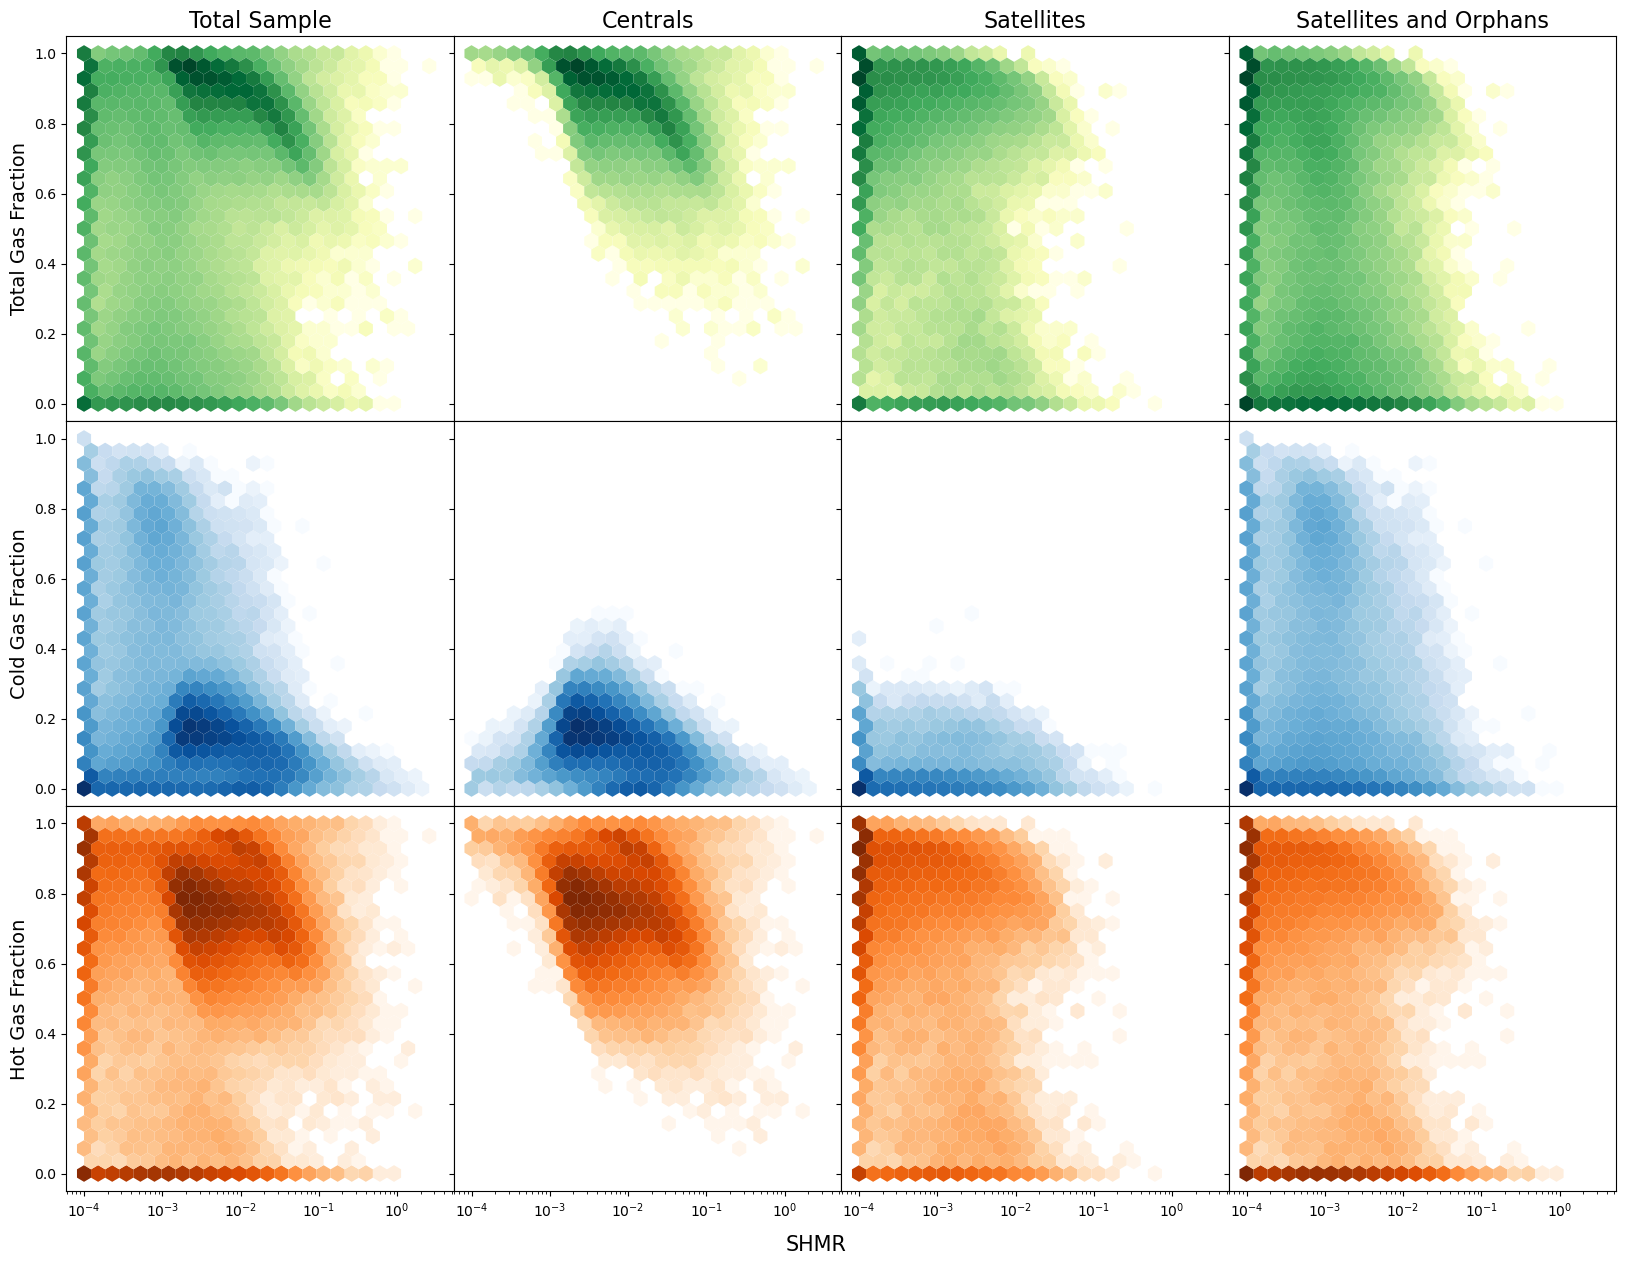

In [6]:
# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

SHMR_threshold = 10**-4  # Minimum SHMR to avoid invalid values

########################################
# Gas Fraction by SHMR
########################################
# Precompute total_gas_fraction, hot_gas_fraction, and cold_gas_fraction for the entire shark_csv dataset
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = (shark_csv['Mhotgas']) / \
                   (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = (shark_csv['Mcoldgas_all']) / \
                    (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = [total_gas_fraction, cold_gas_fraction, hot_gas_fraction]
labels = ["Total Gas Fraction", "Cold Gas Fraction", "Hot Gas Fraction"]
colours = ["YlGn","Blues", "Oranges"]

# Create a 3x4 grid of subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharey='row', sharex='col')
fig.subplots_adjust(wspace=0, hspace=0)

# Apply scalar formatting for readability
for ax_row in axs:
    for ax in ax_row:
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# Loop through each gas fraction type
for row, (gas_fraction, label) in enumerate(zip(gas_fractions, labels)):
    for col, (title, data) in enumerate(datasets):

        # Filter SHMR and gas fraction for the current dataset
        SHMR = data['Mstar_all'] / data['Mhalo_host']
        SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)  # Apply threshold

        gas_fraction_subset = gas_fraction[data.index]# Match gas fraction with the current dataset
        
        # Plot density hexbin
        axs[row, col].hexbin(SHMR, gas_fraction_subset, gridsize=25, xscale='log',
                             reduce_C_function=np.median, mincnt=1, bins='log', linewidth=0, 
                             cmap=colours[row], extent=(-4, 0.5, 0, 1))
        #axs[row, col].scatter(SHMR, gas_fraction_subset, color='Black', alpha=0.5)
        axs[row, col].set_xscale('log')  # Logarithmic x-axis (SHMR)
        axs[row, col].set_yscale('linear')  # Linear y-axis (gas fraction)

        # Set subplot title for the first row only
        if row == 0:
            axs[row, col].set_title(f'{title}', fontsize=16)

        # Set shared y-axis label on the leftmost column
        if col == 0:
            axs[row, col].set_ylabel(label, fontsize=14)

# Add shared x-axis label
fig.text(0.5, 0.07, 'SHMR', ha='center', fontsize=15)

# Show the plot
plt.show()

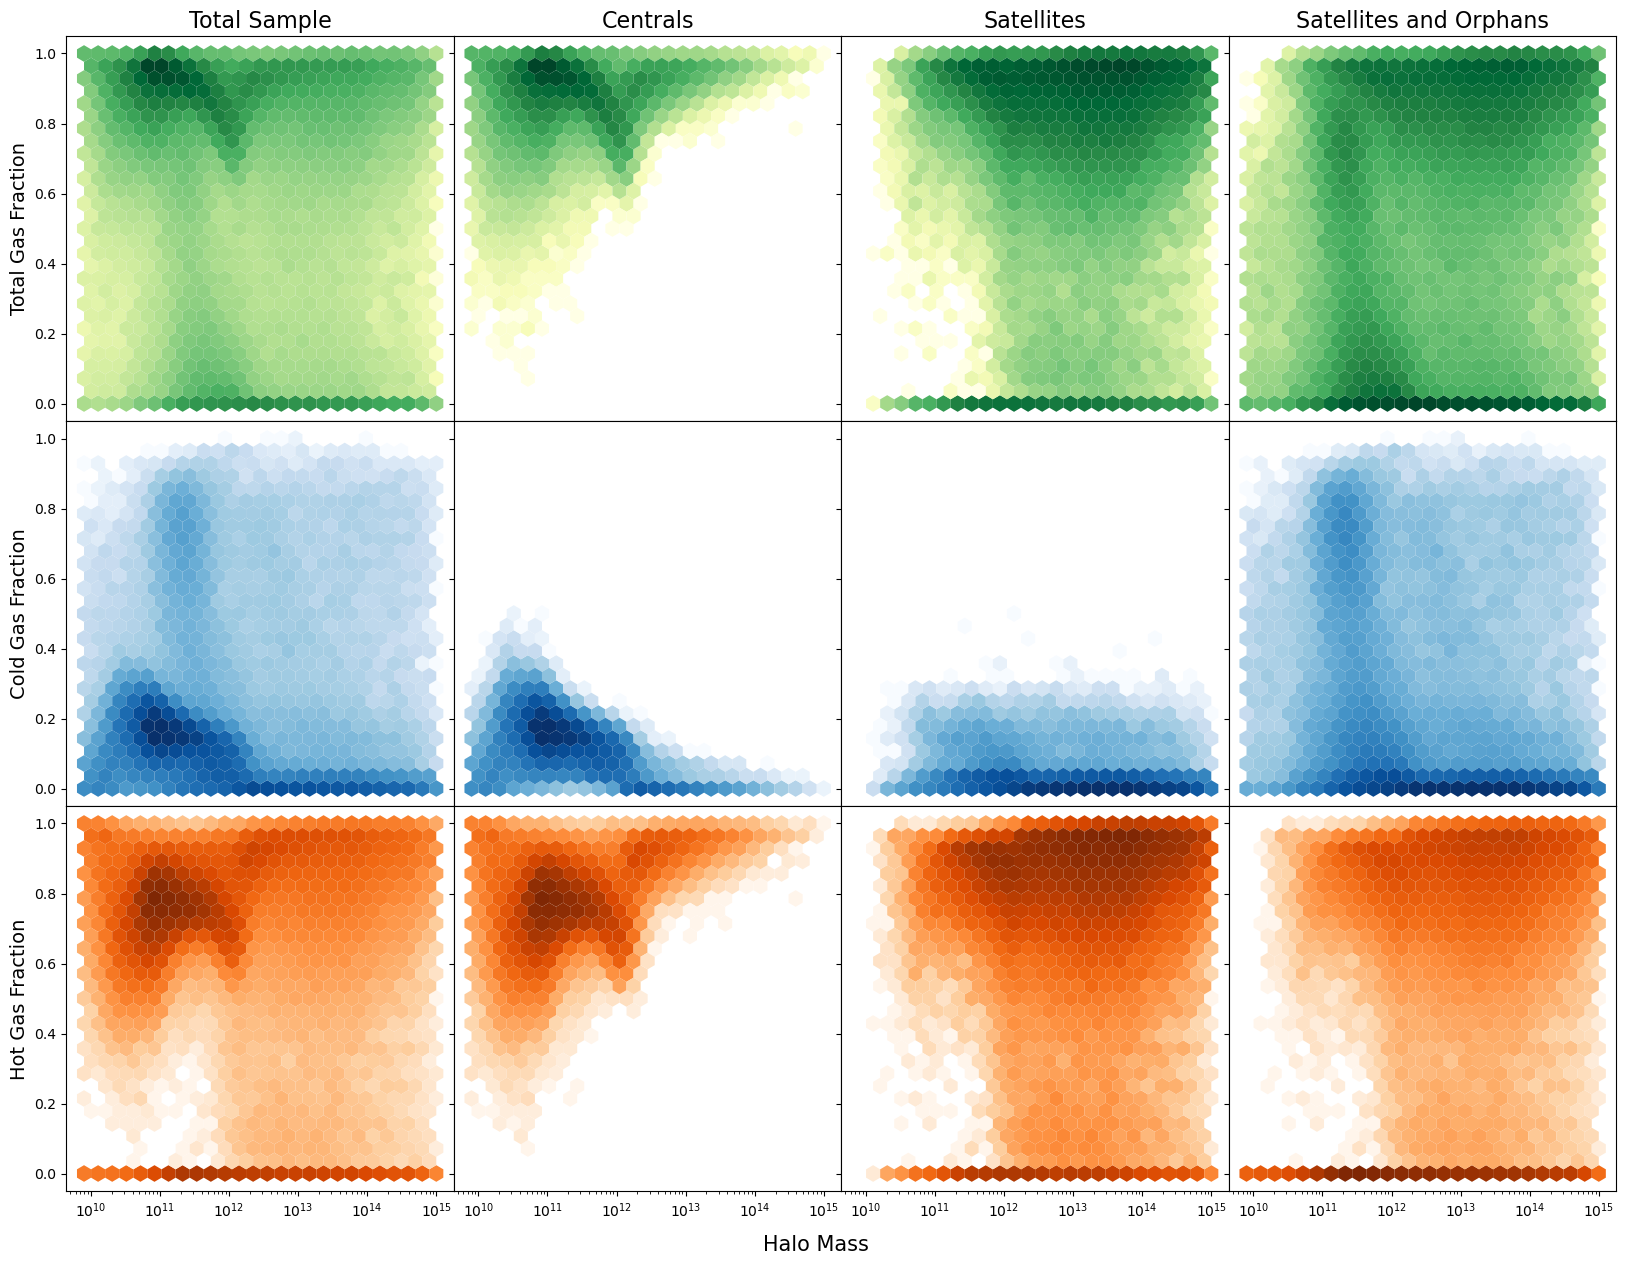

In [7]:
# VS. shark_csv['Mhalo_host']
# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

SHMR_threshold = 10**-4  # Minimum SHMR to avoid invalid values

########################################
# Gas Fraction
########################################
# Precompute total_gas_fraction, hot_gas_fraction, and cold_gas_fraction for the entire shark_csv dataset
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = (shark_csv['Mhotgas']) / \
                   (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = (shark_csv['Mcoldgas_all']) / \
                    (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = [total_gas_fraction, cold_gas_fraction, hot_gas_fraction]
labels = ["Total Gas Fraction", "Cold Gas Fraction", "Hot Gas Fraction"]
colours = ["YlGn","Blues", "Oranges"]

# Create a 3x4 grid of subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharey='row', sharex='col')
fig.subplots_adjust(wspace=0, hspace=0)

# Apply scalar formatting for readability
for ax_row in axs:
    for ax in ax_row:
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# Loop through each gas fraction type
for row, (gas_fraction, label) in enumerate(zip(gas_fractions, labels)):
    for col, (title, data) in enumerate(datasets):

        # Filter SHMR and gas fraction for the current dataset
        HALOmass = data['Mhalo_host']
        #SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)  # Apply threshold

        gas_fraction_subset = gas_fraction[data.index]# Match gas fraction with the current dataset
        
        # Plot density hexbin
        axs[row, col].hexbin(HALOmass, gas_fraction_subset, gridsize=25, xscale='log',
                             reduce_C_function=np.median, mincnt=1, bins='log', linewidth=0, 
                             cmap=colours[row], extent=(9.9, 15, 0, 1))
        #axs[row, col].scatter(SHMR, gas_fraction_subset, color='Black', alpha=0.5)
        axs[row, col].set_xscale('log')  # Logarithmic x-axis (SHMR)
        axs[row, col].set_yscale('linear')  # Linear y-axis (gas fraction)

        # Set subplot title for the first row only
        if row == 0:
            axs[row, col].set_title(f'{title}', fontsize=16)

        # Set shared y-axis label on the leftmost column
        if col == 0:
            axs[row, col].set_ylabel(label, fontsize=14)

# Add shared x-axis label
fig.text(0.5, 0.07, 'Halo Mass', ha='center', fontsize=15)

# Show the plot
plt.show()

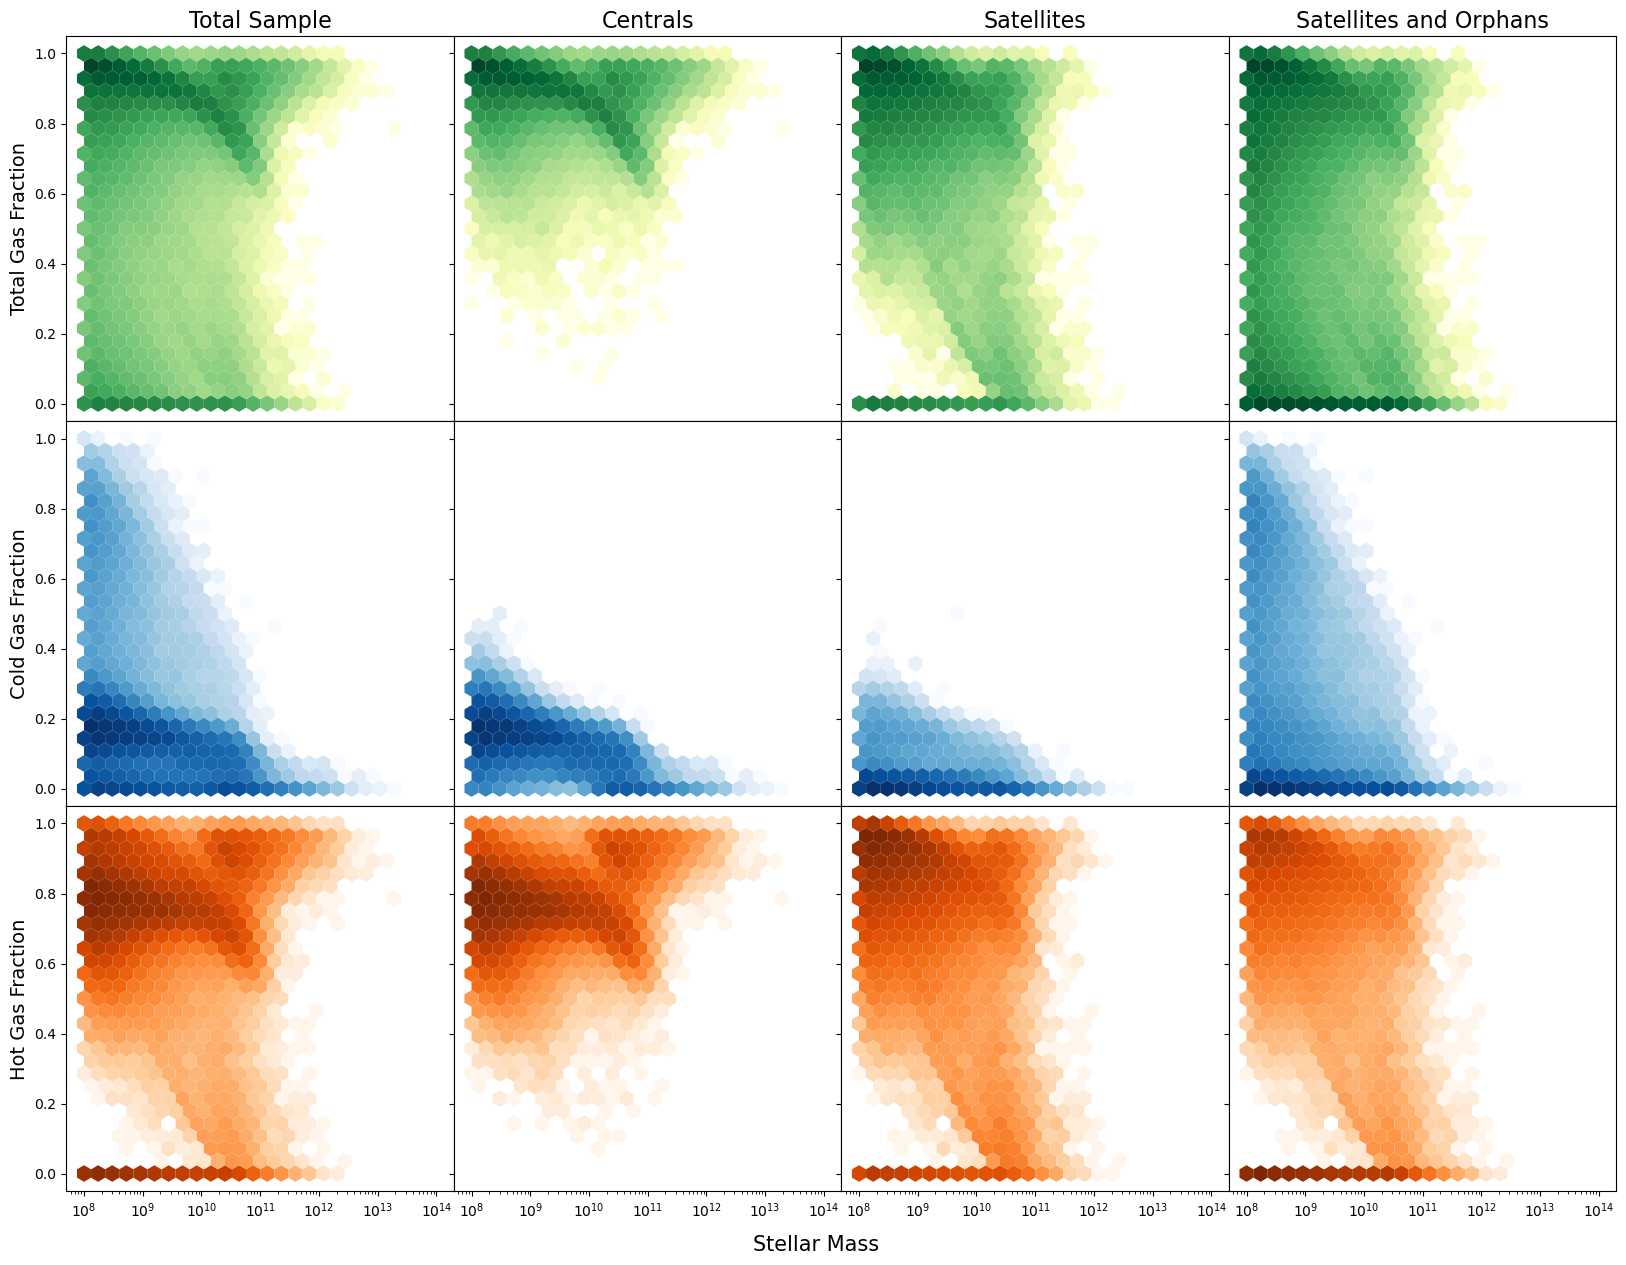

In [8]:
# VS. shark_csv['Mstar_all']
# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

SHMR_threshold = 10**-4  # Minimum SHMR to avoid invalid values

########################################
# Gas Fraction
########################################
# Precompute total_gas_fraction, hot_gas_fraction, and cold_gas_fraction for the entire shark_csv dataset
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = (shark_csv['Mhotgas']) / \
                   (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = (shark_csv['Mcoldgas_all']) / \
                    (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = [total_gas_fraction, cold_gas_fraction, hot_gas_fraction]
labels = ["Total Gas Fraction", "Cold Gas Fraction", "Hot Gas Fraction"]
colours = ["YlGn","Blues", "Oranges"]

# Create a 3x4 grid of subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharey='row', sharex='col')
fig.subplots_adjust(wspace=0, hspace=0)

# Apply scalar formatting for readability
for ax_row in axs:
    for ax in ax_row:
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# Loop through each gas fraction type
for row, (gas_fraction, label) in enumerate(zip(gas_fractions, labels)):
    for col, (title, data) in enumerate(datasets):

        # Filter SHMR and gas fraction for the current dataset
        STELLARmass = data['Mstar_all']
        #SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)  # Apply threshold

        gas_fraction_subset = gas_fraction[data.index]# Match gas fraction with the current dataset
        
        # Plot density hexbin
        axs[row, col].hexbin(STELLARmass, gas_fraction_subset, gridsize=25, xscale='log',
                             reduce_C_function=np.median, mincnt=1, bins='log', linewidth=0, 
                             cmap=colours[row], extent=(8, 14, 0, 1))
        #axs[row, col].scatter(SHMR, gas_fraction_subset, color='Black', alpha=0.5)
        axs[row, col].set_xscale('log')  # Logarithmic x-axis (SHMR)
        axs[row, col].set_yscale('linear')  # Linear y-axis (gas fraction)

        # Set subplot title for the first row only
        if row == 0:
            axs[row, col].set_title(f'{title}', fontsize=16)

        # Set shared y-axis label on the leftmost column
        if col == 0:
            axs[row, col].set_ylabel(label, fontsize=14)

# Add shared x-axis label
fig.text(0.5, 0.07, 'Stellar Mass', ha='center', fontsize=15)

# Show the plot
plt.show()

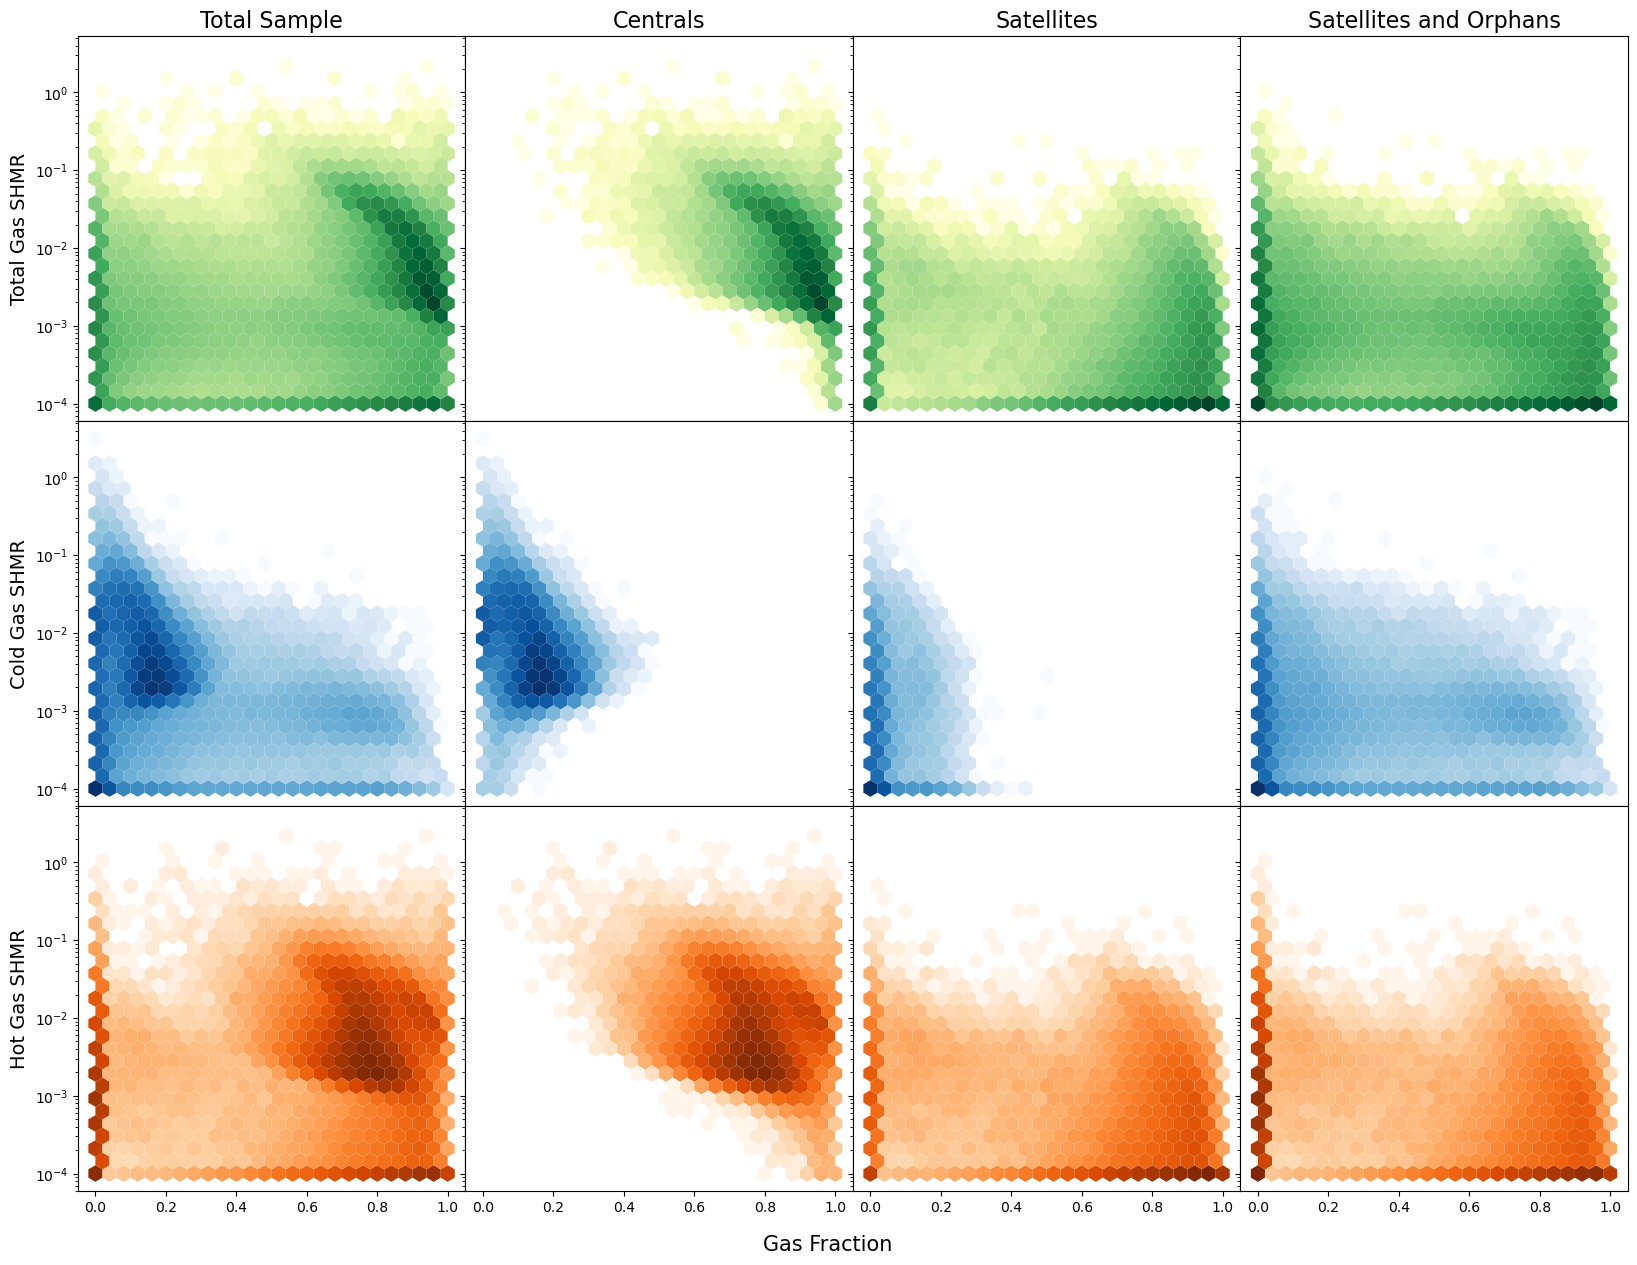

In [9]:
# FLIPPED AXES

# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

SHMR_threshold = 10**-4  # Minimum SHMR to avoid invalid values

########################################
# Gas Fraction
########################################
# Precompute total_gas_fraction, hot_gas_fraction, and cold_gas_fraction for the entire shark_csv dataset
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = (shark_csv['Mhotgas']) / \
                   (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = (shark_csv['Mcoldgas_all']) / \
                    (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = [total_gas_fraction, cold_gas_fraction, hot_gas_fraction]
labels = ["Total Gas SHMR", "Cold Gas SHMR", "Hot Gas SHMR"]
colours = ["YlGn","Blues", "Oranges"]

# Create a 3x4 grid of subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharey='row', sharex='col')
fig.subplots_adjust(wspace=0, hspace=0)

# Apply scalar formatting for readability
for ax_row in axs:
    for ax in ax_row:
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# Loop through each gas fraction type
for row, (gas_fraction, label) in enumerate(zip(gas_fractions, labels)):
    for col, (title, data) in enumerate(datasets):

        # Filter SHMR and gas fraction for the current dataset
        SHMR = data['Mstar_all'] / data['Mhalo_host']
        SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)  # Apply threshold

        gas_fraction_subset = gas_fraction[data.index]# Match gas fraction with the current dataset
        
        # Plot density hexbin
        axs[row, col].hexbin( gas_fraction_subset, SHMR, gridsize=25, yscale='log',
                             reduce_C_function=np.median, mincnt=1, bins='log', linewidth=0, 
                             cmap=colours[row], extent=(0, 1,-4, 0.5))
        #axs[row, col].scatter(SHMR, gas_fraction_subset, color='Black', alpha=0.5)
        axs[row, col].set_yscale('log')  # Logarithmic x-axis (SHMR)
        axs[row, col].set_xscale('linear')  # Linear y-axis (gas fraction)

        # Set subplot title for the first row only
        if row == 0:
            axs[row, col].set_title(f'{title}', fontsize=16)

        # Set shared y-axis label on the leftmost column
        if col == 0:
            axs[row, col].set_ylabel(label, fontsize=14)

# Add shared x-axis label
fig.text(0.5, 0.07, 'Gas Fraction', ha='center', fontsize=15)

# Show the plot
plt.show()

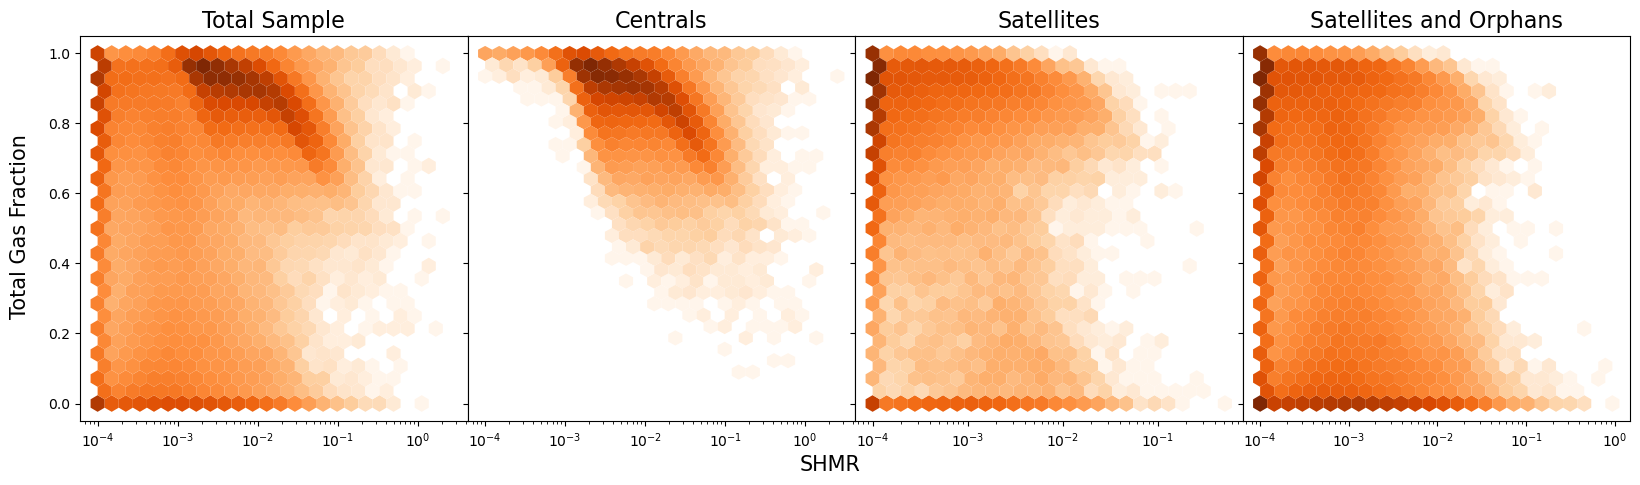

In [66]:
########################################
# Density Plots (TOTAL Gas Fraction vs. SHMR with Points and Error Bars)
########################################

# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

SHMR_threshold = 10**-4  # Minimum SHMR to avoid invalid values

# Precompute total_gas_fraction, hot gas fraction, and cold gas fraction for the entire shark_csv dataset
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = (shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = (shark_csv['Mcoldgas_all']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = ["total_gas_fraction", "hot_gas_fraction", "cold_gas_fraction"] 

# Create a 1x4 grid of subplots -- GPT: CHANGE THIS TO A 3x4 grid of subplots! -- 
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0)

# Apply scalar formatting for readability
for ax in axs:
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):
    
    # Filter SHMR and gas fraction for the current dataset
    SHMR = data['Mstar_all'] / data['Mhalo_host']
    SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)  # Apply threshold

    gas_fraction_subset = total_gas_fraction[data.index]  # Match gas fraction with the current dataset

    # Plot density hexbin
    axs[i].hexbin(SHMR, gas_fraction_subset, gridsize=25, xscale='log',
                  reduce_C_function=np.sum, mincnt=1, bins='log', linewidth=0, cmap='Oranges')
    axs[i].set_xscale('log')  # Logarithmic x-axis (SHMR)
    axs[i].set_yscale('linear')  # Linear y-axis (gas fraction)

    # Set subplot title
    axs[i].set_title(f'{title}', fontsize=16)

# Add shared x-axis and y-axis labels
fig.text(0.5, 0.01, 'SHMR', ha='center', fontsize=15)
fig.text(0.09, 0.5, 'Total Gas Fraction', va='center', rotation='vertical', fontsize=15)

# Add legend to the first subplot
# axs[0].legend(loc="upper right", fontsize=8.5)

# Show the plot
plt.show()

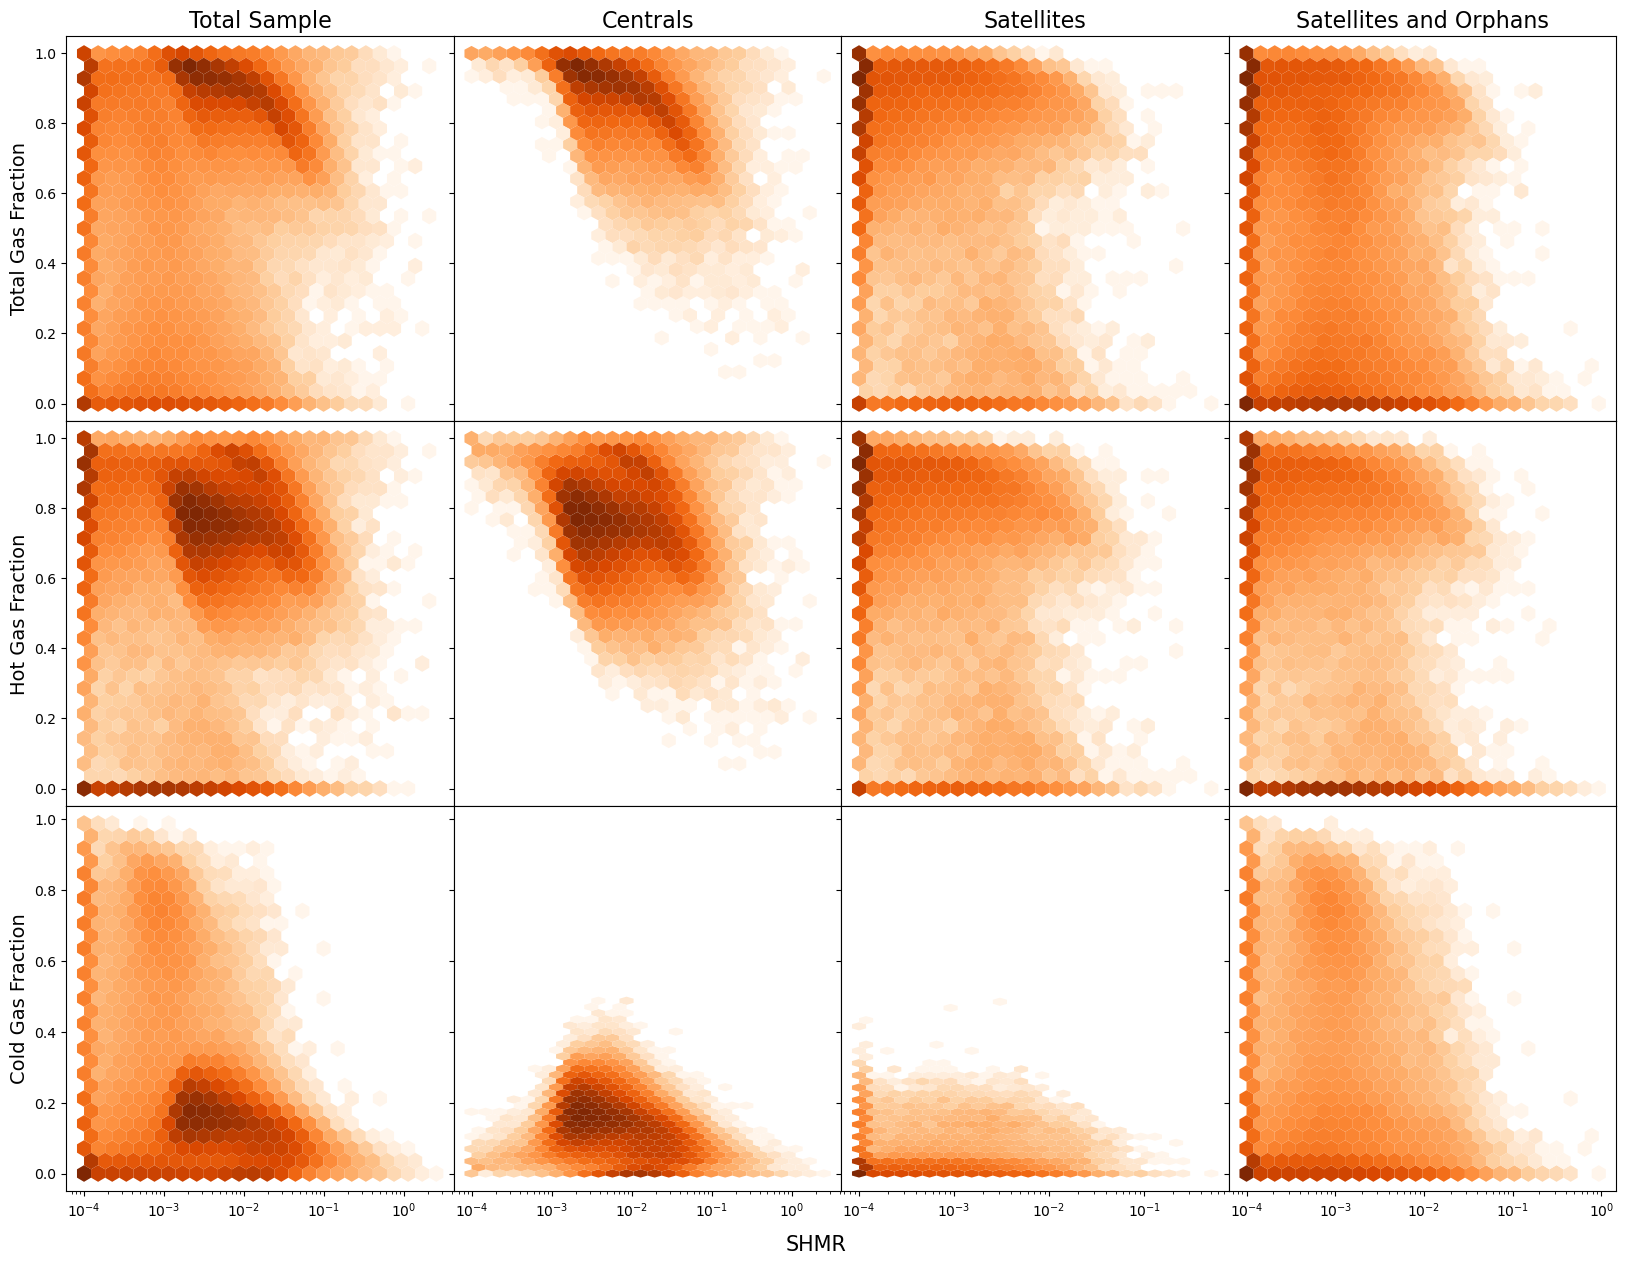

In [67]:
# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

SHMR_threshold = 10**-4  # Minimum SHMR to avoid invalid values

# Precompute total_gas_fraction, hot_gas_fraction, and cold_gas_fraction for the entire shark_csv dataset
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = (shark_csv['Mhotgas']) / \
                   (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = (shark_csv['Mcoldgas_all']) / \
                    (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = [total_gas_fraction, hot_gas_fraction, cold_gas_fraction]
labels = ["Total Gas Fraction", "Hot Gas Fraction", "Cold Gas Fraction"]
colours = []

# Create a 3x4 grid of subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharey='row', sharex='col')
fig.subplots_adjust(wspace=0, hspace=0)

# Apply scalar formatting for readability
for ax_row in axs:
    for ax in ax_row:
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# Loop through each gas fraction type
for row, (gas_fraction, label) in enumerate(zip(gas_fractions, labels)):
    for col, (title, data) in enumerate(datasets):

        # Filter SHMR and gas fraction for the current dataset
        SHMR = data['Mstar_all'] / data['Mhalo_host']
        SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)  # Apply threshold

        gas_fraction_subset = gas_fraction[data.index]  # Match gas fraction with the current dataset

        # Plot density hexbin
        axs[row, col].hexbin(SHMR, gas_fraction_subset, gridsize=25, xscale='log',
                             reduce_C_function=np.sum, mincnt=1, bins='log', linewidth=0, cmap='Oranges')
        axs[row, col].set_xscale('log')  # Logarithmic x-axis (SHMR)
        axs[row, col].set_yscale('linear')  # Linear y-axis (gas fraction)

        # Set subplot title for the first row only
        if row == 0:
            axs[row, col].set_title(f'{title}', fontsize=16)

        # Set shared y-axis label on the leftmost column
        if col == 0:
            axs[row, col].set_ylabel(label, fontsize=14)

# Add shared x-axis label
fig.text(0.5, 0.07, 'SHMR', ha='center', fontsize=15)

# Show the plot
plt.show()